In [1]:
import pygsp
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pygsp.graphs import Graph
from scipy.optimize import least_squares

from ex2_utils import describe, matrix_poly, \
    adj_matrix_from_coords_limited

pygsp.plotting.BACKEND = 'matplotlib'

df = pd.read_csv('../resources/us_obesity_by_county.csv', sep=',')

df.head()

,FIPS,LATITUDE,LONGITUDE,ADULT_OBESITY_2015,ADULT_OBESITY_2016,GRAPH_SIGNAL
0,1001,32.536382,-86.644490,0.313,0.309,-1
1,1003,30.659218,-87.746067,0.250,0.267,1
2,1005,31.870670,-85.405456,0.384,0.408,1
3,1007,33.015893,-87.127148,0.373,0.401,1
4,1009,33.977448,-86.567246,0.309,0.324,1


In [2]:
coords = df[['LONGITUDE', 'LATITUDE']].to_numpy()
N = len(coords)

A = adj_matrix_from_coords_limited(coords, limit=4)

print("Description of the graph:")
describe(nx.from_numpy_matrix(A))

G = Graph(A, coords=coords, plotting={
    'vertex_size': 40,
    'vertex_color': (0.12, 0.47, 0.71, 1),
    'edge_color': (0.5, 0.5, 0.5, 0.5),
    'edge_width': 1
})

100%|██████████| 3107/3107 [00:00<00:00, 4979.78it/s]


Description of the graph:
n_nodes: 3108
n_edges: 7179
n_self_loops: 0
density: 0.0014868655036019054
is_connected: True
n_connected_components: 1
is_directed: False
is_weighted: True


Text(0.5, 1.0, 'Degree distribution')

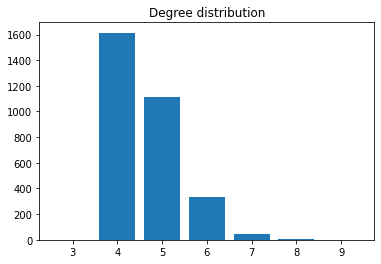

In [3]:
Gnx = nx.from_numpy_matrix(A)
df_deg = pd.DataFrame({'Degree': dict(Gnx.degree).values()}, index=dict(Gnx.degree).keys())
deg_count = df_deg['Degree'].value_counts()
plt.bar(deg_count.index.tolist(), deg_count.values)
plt.title("Degree distribution")

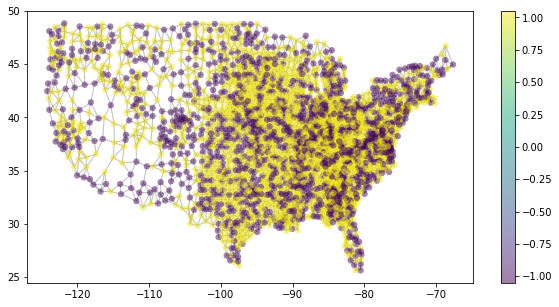

In [4]:
# Graph signal: which counties showed an increase in obesity
# rate from 2015 to 2016?
s_true = df['GRAPH_SIGNAL'].copy().to_numpy()

def show_graph_signal(G, s, output="graph01.pdf"):
    G.plot_signal(s, title="")

    height_inches = 5
    fig = plt.gcf()
    fig.set_size_inches(2 * height_inches, height_inches, forward=True)
    fig.savefig(output)

show_graph_signal(G, s_true, output="graph01.pdf")

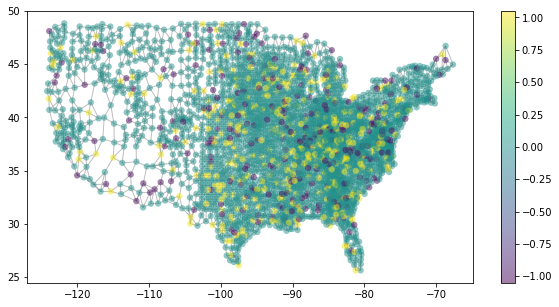

In [5]:
unknown_frac = 0.80  # test size
train_frac = 0.5 * (1 - unknown_frac)  # train size
valid_size = 0.5 * (1 - unknown_frac)  # size of validation set
N = len(s_true)

s_known = s_true.copy()
rnd = np.random.RandomState(seed=2021)
shuffled_indices = rnd.permutation(N)

idx_unknown = shuffled_indices[:int(unknown_frac * N)]
idx_train = shuffled_indices[
    int(unknown_frac * N) : (int(unknown_frac * N) + int(train_frac * N))]
idx_valid = shuffled_indices[(int(unknown_frac * N) + int(train_frac * N)):]

s_known[idx_unknown] = 0
mask_unknown = s_known == 0

s_train = s_true.copy()
s_train[idx_unknown] = 0
s_train[idx_valid] = 0

show_graph_signal(G, s_known, output="graph02.pdf")

In [6]:
# Initial value of filter taps
rnd = np.random.RandomState(2021)
L = 10
h0 = 10 + 2 * rnd.randn(L+1)

# Pre-computing the array of matrices
M = np.array([
    np.diag(s_known) @ np.linalg.matrix_power(A, i) @ s_train
    for i in range(L+1)]).T

In [7]:
def objective(filter_taps):
    return M @ filter_taps - np.ones(N)

res = least_squares(
    objective, h0, max_nfev=500, verbose=2, ftol=1e-10, xtol=1e-10)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7977e+19                                    3.01e+18    
       1              2         2.4123e+03      1.80e+19       3.43e+01       6.94e+09    
       2              3         1.3978e+03      1.01e+03       5.91e+00       3.55e+03    
       3              4         1.3978e+03      3.09e-11       1.08e-07       4.29e-06    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.7977e+19, final cost 1.3978e+03, first-order optimality 4.29e-06.


In [8]:
hA = matrix_poly(res.x, A)
pred = hA @ s_known

s_true_bin = (s_true > 0).astype(int)
pred_bin = (pred > 0).astype(int)

def evaluate(idx):
    return (s_true_bin[idx] == pred_bin[idx]).sum() / len(idx)

# Accuracy in the train set
print(evaluate(idx_train))

# Accuracy in the validation set
print(evaluate(idx_valid))

# Accuracy in the test set
print(evaluate(idx_unknown))

1.0
1.0
0.5249396621078037


# Filter frequency response

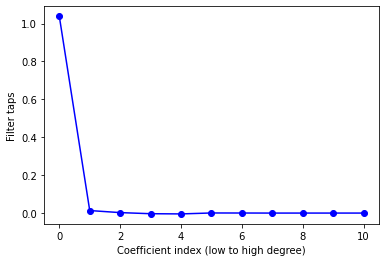

In [9]:
# Filter taps:
plt.figure()
plt.plot(res.x, 'bo-')
plt.xlabel("Coefficient index (low to high degree)")
plt.ylabel("Filter taps")
plt.show()

In [10]:
# Eigendecomposition of A
eigA, V = np.linalg.eig(A)
# Eigenvalue with highest magnitude
eigmax = eigA[np.argmax(np.abs(eigA))]
# Indices which sort the frequencies from low to high: they're the indices
# which sort the magnitude of the difference between each eigenvalue
# and the magnitude of the one with highest magnitude
idx_frequency = np.argsort(np.abs(eigA - np.abs(eigmax)))

In [11]:
h = np.polynomial.Polynomial(res.x)
freq_resp = np.abs(h(eigA))

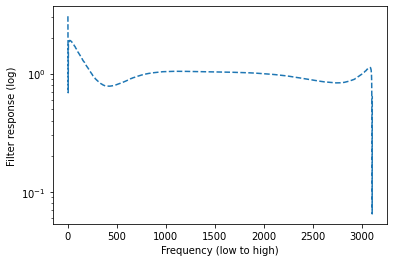

In [12]:
plt.figure()
plt.plot(freq_resp[idx_frequency], '--', markersize=3)
plt.yscale('log')
plt.xlabel("Frequency (low to high)")
plt.ylabel("Filter response (log)")
plt.show()